# Introduction

Le but de ce projet était d'expliquer l'évolution de la dette des administrations publiques grâce à des proxys indiquant l'état de l'économie. 
Il aurait été facile de reconstituer précisément la dette en prenant en compte les recettes et dépenses de l'Etat, mais cela s'apparenterait plus à un travail de comptabilité nationale.


C'est pourquoi nous avons voulu privilégier des indicateurs de la situation économique française : chômage, nombre de créations et de faillites d'entreprises, taux de change, balance des paiements, natalité, cac40, taux directeurs, afin d'observer des corrélations entre la conjoncture française via ces proxys et l'augmentation de la dette.  


## Plan 

### I Construction de la base de données

1) Récupération des données INSEE via l'API pynsee

2) Autres données
- 2-1 Taux de change et CAC 40
- 2-2 Scraping des taux directeurs

3) Fusion des bases de données
- 3-1 Bases de données trimestrielles
- 3-2 Complétion par les valeurs les plus proches
- 3-3 Jointure et base de données finale


### II Statistiques descriptives

1) Variables macroéconomiques

2) Politique monétaire et taux directeurs

3) Plotly


### III Modéliation

1) Régression classique 

2) Détection de grandes périodes et points de rupture

3) Essai et comparaison de nouveaux modèles prédictifs

- 3-1 Interprétation des résultats
- 3-2 Prédiction et comparaison de modèles

### Conclusion

# I Construction de la base de données

## 1) Récupération des données INSEE via l'API pynsee

Notre sujet abordant des questions de politiques publiques, il nous était impensable de ne pas commencer à chercher des données sur le site de l'INSEE. Et nous avons en effet trouvé ce que nous cherchions. Restait encore la question de l'import des bases de données. 
Une première option s'offrait à nous, plus simple, mais plus répétitive et moins performante : télécharger les bases de données une par une, puis les uploader sur le github. 
La seconde option est celle que nous avons utilisée : nous avons importé les bases de données via l'API pynsee, ce qui nous permettait de ne pas rencontrer les mêmes difficultés. 

In [3]:
#Download Pypi package 
#pip install pynsee[full]
#pip install matplotlib
#pip install seaborn
#pip install scipy
import os
import subprocess
import pandas as pd
import re
import numpy as np

from pynsee.utils.init_conn import init_conn
init_conn(insee_key='GvulBMLLd4u26RRdMPxYlvqjvHYa', insee_secret='MvDm1OBD_s1a4A33InvrYRT_wEga')

from pynsee.macrodata import * 
from pynsee.macrodata.get_series_list import get_series_list
from pynsee.macrodata.get_series import get_series

Please subscribe to Metadata API on api.insee.fr !
Please subscribe to Local Data API on api.insee.fr !


Nous avons ensuite créé deux fonctions : 
- clean_filename : permettait d'avoir un nom de fichier 'propre' en ne gardant que des caractères alphanumériques
- import_and_save_data : permet d'importer le fichier souhaité (via l'id_bank de l'INSEE) en le renommant (en donnant le nom souhaité)

In [4]:
def clean_filename(name):
    return re.sub(r'[^a-zA-Z0-9]', '_', str(name))

def import_and_save_data(id_bank, dataframe_name):
    data = get_series(id_bank)
    data_filtered = data.loc[:, ['DATE', 'OBS_VALUE']] #Sélection des variables d'intérêt
    data_filtered['DATE'] = pd.to_datetime(data_filtered['DATE'])

    new_column_name = clean_filename(dataframe_name) 
    data_filtered = data_filtered.rename(columns={'OBS_VALUE': new_column_name}) # Renommer la colonne OBS_VALUE avec le nom du df
    print(data_filtered.head()) #Vérification des données

    csv_filename = f'datas/{clean_filename(dataframe_name)}_filtered.csv'
    data_filtered.to_csv(csv_filename, index=False) #Sauvegarde dans un fichier csv

    return data_filtered

Il ne nous restait donc plus qu'à exécuter le code pour les données que nous souhaitions importer : 

In [5]:
governement_negotiable_debts = import_and_save_data('001711531', 'negotiable_debts')
data_firms_creation = import_and_save_data('010755537', 'firms_creation')
data_unemployment_rate = import_and_save_data('001515842', 'unemployment_rate')
data_BOP = import_and_save_data('001694057', 'BOP')
data_natality_rate = import_and_save_data('000436392', 'natality_rate')
data_business_insolvencies = import_and_save_data('001656164', 'business_insolvencies')

Getting datasets list: 100%|██████████| 200/200 [00:00<00:00, 2097.83it/s]


        DATE  negotiable_debts
0 2009-01-01           1018094
1 2009-02-01           1040865
2 2009-03-01           1063788
3 2009-04-01           1074757
4 2009-05-01           1092161


1/1 - Getting series: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


        DATE  firms_creation
0 2000-01-01           21525
1 2000-02-01           20798
2 2000-03-01           22342
3 2000-04-01           22596
4 2000-05-01           21197


1/1 - Getting series: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


        DATE  unemployment_rate
0 1982-01-01                6.7
1 1982-04-01                6.8
2 1982-07-01                7.0
3 1982-10-01                7.0
4 1983-01-01                7.0


1/1 - Getting series: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


        DATE    BOP
0 2008-01-01  65642
1 2008-02-01  65427
2 2008-03-01  64356
3 2008-04-01  65569
4 2008-05-01  64614


1/1 - Getting series: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


        DATE  natality_rate
0 1975-01-01           14.0
1 1975-02-01           14.4
2 1975-03-01           14.7
3 1975-04-01           15.8
4 1975-05-01           16.1


1/1 - Getting series: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

        DATE  business_insolvencies
0 1990-01-01                  12117
1 1990-04-01                  11310
2 1990-07-01                   9416
3 1990-10-01                  13286
4 1991-01-01                  14197


## 2) Import des autres données : 

   ### 2-1 Taux de change et CAC40

Afin de récupérer le taux de change ainsi que l'indice du CAC 40, il n'était pas possible de recourir à la base de données de l'INSEE. Nous avons cependant trouvé des données en open-data, disponibles à ces adresses : 
- https://www.investing.com/currencies/eur-usd-historical-data pour le taux de change au certain €/$
- https://fr.investing.com/indices/france-40-historical-data pour le CAC 40

Cette méthode présente néanmoins les mêmes désavantages que ceux listés pour la première option de l'import des bases de données de l'INSEE. Nous l'avons donc seulement choisie en raison du nombre limité de bases de données à importer (deux) et d'absence d'autres bases aussi accessibles et complètes.
Il ne suffisait que de retravailler les données afin d'obtenir le format de date souhaité et le format anglo-saxon pour les float (. à la place de ,)


NOTE : il n'est pas nécessaire d'exécuter ce fichier, à moins d'avoir téléchargé les fichiers à partir de la page web indiquée. Les fichiers csv sont toujours disponibles sur le github, mais il est possible d'exécuter le code en changant le nom des fichiers dans le dictionnaire files.

In [6]:
#changer le chemin d'accès aux fichiers csv en fonction du chemin local
destination_folder = "datas"
files = {
    'C:\\Users\\mathi\\Downloads\\CAC 40 Historical Data (2).csv': 'CAC_40.csv',
    'C:\\Users\\mathi\\Downloads\\EUR_USD Historical Data (3).csv': 'EUR_USD.csv'
}

for file_path, new_name in files.items():
    df = pd.read_csv(file_path, encoding='utf-8')
    df.rename(columns={'Date': 'DATE'}, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y', errors='coerce') #Conversion de la date à un format standard
    df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')
    print("date successful")

    if new_name == 'CAC_40.csv':    
        df = df[['DATE', 'Price']]
        df.rename(columns={'Price': 'Valuation'}, inplace=True)
        print(new_name, df.head())
        df['Valuation'] = df['Valuation'].str.replace(',', '').astype(float)

    elif new_name == 'EUR_USD.csv':
        df = df[['DATE', 'Price']]
        df.rename(columns={'Price': 'Exch_rate'}, inplace=True)
        print(new_name, df.head())
        df['Exch_rate'] = df['Exch_rate'].replace({',': '.', '"': ''}, regex=True).astype(float)

    new_path = os.path.join(destination_folder, new_name)
    df.to_csv(new_path, index=False)

date successful
CAC_40.csv          DATE Valuation
0  2023-12-01  7,573.93
1  2023-11-01  7,310.77
2  2023-10-01  6,885.65
3  2023-09-01  7,135.06
4  2023-08-01  7,316.70
date successful
EUR_USD.csv          DATE  Exch_rate
0  2023-12-01     1.0977
1  2023-11-01     1.0886
2  2023-10-01     1.0576
3  2023-09-01     1.0570
4  2023-08-01     1.0841


### 2-2 Taux directeurs : scraping

Un autre challenge restait celui de la récupération des taux directeurs. En effet, ceux-ci jouent un rôle clé dans l'évolution de la dette en ce qu'ils déterminent les intérêts à payer. Nous avons décidé de les récupérer sur le site de la Banque Centrale Européenne (BCE, ou ECB en anglais). Cette fois-ci avec plusieurs difficultés : 
- les années n'étaient pas présentes sur toutes les lignes et pouvaient fonctionner par "groupe"  
- les dates n'étaient pas au format standard mais avec des abréviations
- les chiffres négatifs étaient précédés d'un U+2212 au lieu du - classique
- les numéros de note pour les notes de bas de page étaient affichés dans la date. Ex : 15 Oct.4

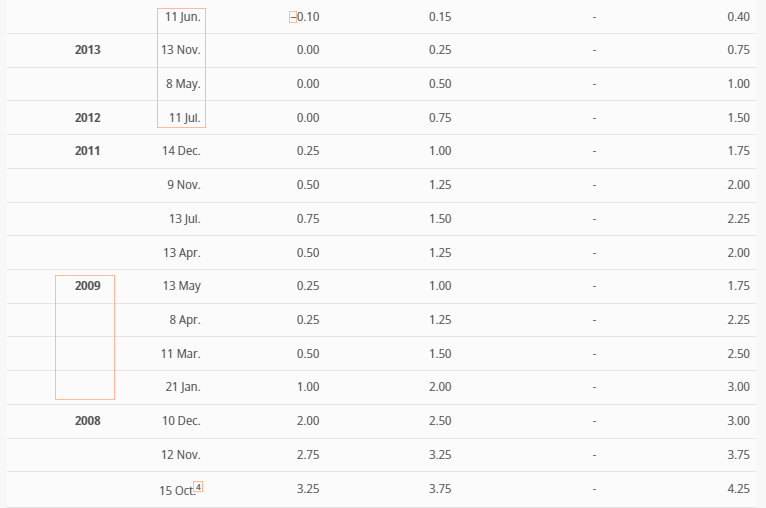

In [7]:
#Import des librairies
# pip install -q lxml
# pip install webdriver-manager

import bs4
import lxml
import urllib
import re

from urllib import request
from datetime import datetime

url_ecb = "https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html"

request_text = request.urlopen(url_ecb).read()
page = bs4.BeautifulSoup(request_text, "html.parser")

policy_rates_df = page.find('table')
table_body = policy_rates_df.find('tbody')
rows = table_body.find_all('tr')

#Compléter la première colonne avec la valeur précédente s'il n'y en a aucune 

data_temp = []

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if cols[0] == '':
        cols[0] = previous_value
    previous_value = cols[0]
    data_temp.append(cols)

columns = ['Year', 'Date', 'Deposit facility', 'Fixed rate', 'Minimum bid rate', 'Marginal lending facility']
policy_rates_df = pd.DataFrame(data_temp, columns=columns)
policy_rates_df['Deposit facility'] = policy_rates_df['Deposit facility'].str.replace('−', '-') #Remplacement du signe U+2212 avec un signe moins - 

print(policy_rates_df.head())


   Year     Date Deposit facility Fixed rate Minimum bid rate  \
0  2023  20 Sep.             4.00       4.50                -   
1  2023   2 Aug.             3.75       4.25                -   
2  2023  21 Jun.             3.50       4.00                -   
3  2023   10 May             3.25       3.75                -   
4  2023  22 Mar.             3.00       3.50                -   

  Marginal lending facility  
0                      4.75  
1                      4.50  
2                      4.25  
3                      4.00  
4                      3.75  


Une fois le problème des années pas toujours présentes dans la première colonne, il nous a fallu régler les deux problèmes restants (pas de date dans un format standard comme DD/MM/YYYY, mais avec des abréviations).
Nous avons d'abord tenté d'utiliser pd.to_datetime, mais il s'est avéré qu'il n'arrivait pas bien à assimiler le format. Nous avons alors eu l'idée d'utiliser une expression régulière : 
- (\d{1,2}): correspond à 1 ou 2 chiffres (\d) qui représentent le jour du mois 
- \s: un espace ou une tabulation (dans notre cas, l'espace entre le jour et l'abréviation du mois)
- (\w{3}): 3 caractères alphanumériques, représentant les abréviations de tous les mois étaient abrégés avec 3 caractères alphanumériques

Nous avons ensuite utilisé la fonction Map afin de passer des abréviations des mois au format souhaité YYYY-MM-DD

In [8]:
extracted_date = policy_rates_df['Date'].str.extract(r'(\d{1,2})\s(\w{3})')

month_map = {
    'Jan': '-01-', 'Feb': '-02-', 'Mar': '-03-',
    'Apr': '-04-', 'May': '-05-', 'Jun': '-06-',
    'Jul': '-07-', 'Aug': '-08-', 'Sep': '-09-',
    'Oct': '-10-', 'Nov': '-11-', 'Dec': '-12-'
}

# Construction de la date tel que le format est YYYY-MM-DD
policy_rates_df['Date'] = (
    policy_rates_df['Year'].astype(str) + 
    extracted_date[1].map(month_map) + 
    extracted_date[0].astype(str)
)

policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'], format='%Y-%m-%d', errors='coerce')
print(policy_rates_df.head())

policy_rates_df.drop(['Year', 'Minimum bid rate'], axis=1, inplace=True) #Drop de la colonne Year comme elle est redondante avec la colonne Date, et Minimum bid rate n'est pas pertinent


#On s'assure que les colonnes souhaitées sont bien du type float 

field_float = ['Deposit facility', 'Fixed rate', 'Marginal lending facility']

for col in field_float:
    policy_rates_df[col] = pd.to_numeric(policy_rates_df[col], errors='coerce')

policy_rates_df[field_float] = policy_rates_df[field_float].astype(float)

 
print(policy_rates_df.head())  

policy_rates_df.to_csv('datas/' + 'policy_rates.csv', index=False) #Sauvegarde du fichier en csv

   Year       Date Deposit facility Fixed rate Minimum bid rate  \
0  2023 2023-09-20             4.00       4.50                -   
1  2023 2023-08-02             3.75       4.25                -   
2  2023 2023-06-21             3.50       4.00                -   
3  2023 2023-05-10             3.25       3.75                -   
4  2023 2023-03-22             3.00       3.50                -   

  Marginal lending facility  
0                      4.75  
1                      4.50  
2                      4.25  
3                      4.00  
4                      3.75  
        Date  Deposit facility  Fixed rate  Marginal lending facility
0 2023-09-20              4.00        4.50                       4.75
1 2023-08-02              3.75        4.25                       4.50
2 2023-06-21              3.50        4.00                       4.25
3 2023-05-10              3.25        3.75                       4.00
4 2023-03-22              3.00        3.50                       3.

## 3) Fusion des bases de données

L'objectif est d'avoir une base de données mensuelle avec tous nos indicateurs. Celle-ci s'obtient par une jointure des bases précédentes sur la colonne 'DATE', au format YYYY-MM-DD. Il a fallu retravailler deux éléments : 

### 3-1 Bases de données trimestrielles

Les données trimestrielles présentaient deux problématiques différentes, avec deux réponses différentes : 
- interpolation linéaire : s'il y a 5% de taux de chômage au mois m et 8% à la date m+3, alors on considère qu'il y a 6% en m+1 et 7% en m+2
- répartition uniforme : s'il y a 3000 faillites au cours du premier trimestre d'une année, alors on considère qu'il y a eu 1000 faillites par mois

In [9]:
data_folder = 'datas/'

# Chargement des fichiers CSV depuis le dossier "datas"
business_insolvencies = pd.read_csv(data_folder + 'business_insolvencies_filtered.csv')
firms_creation = pd.read_csv(data_folder + 'firms_creation_filtered.csv')
unemployment_rate = pd.read_csv(data_folder + 'unemployment_rate_filtered.csv')

def fill_missing_months_linear(data, column_name, output_folder='datas/'):
    # Conversion de la colonne 'DATE' en type datetime et tri par date
    data['DATE'] = pd.to_datetime(data['DATE'])
    data.set_index('DATE', inplace=True)
    
    data_resampled = data.resample('MS').mean()
    data_resampled = data_resampled.asfreq('MS')
    data_resampled = data_resampled.interpolate(method='linear')
    
    csv_filename = f'{output_folder}/{clean_filename(column_name)}_mensual.csv'
    data_resampled.to_csv(csv_filename, index=True)
    
    return data_resampled

def fill_missing_months_divided(data, column_name, output_folder='datas/'):

    data['DATE'] = pd.to_datetime(data['DATE'])    
    data.set_index('DATE', inplace=True)

    data_resampled = data.resample('MS').mean() # Rééchantillonnage à une fréquence mensuelle
    data_resampled = data_resampled.asfreq('MS') # Ajout de lignes pour les mois manquants
    data_resampled = data_resampled / 3 #Répartition uniforme
    data_resampled = data_resampled.fillna(method='ffill') # remplacement des valeurs manquantes par la valeur du mois précédent (divisée par 3)

    csv_filename = f'{output_folder}/{clean_filename(column_name)}_mensual.csv'
    data_resampled.to_csv(csv_filename, index=True)
    
    return data_resampled

filled_divided_business_insolvencies = fill_missing_months_divided(business_insolvencies, 'business_insolvencies')
filled_linear_unemployment_rate = fill_missing_months_linear(unemployment_rate, 'unemployment_rate')

C:\Users\mathi\AppData\Local\Temp\ipykernel_32136\1924501527.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_resampled = data_resampled.fillna(method='ffill') # remplacement des valeurs manquantes par la valeur du mois précédent (divisée par 3)


### 3-2 Complétion par les valeurs les plus proches

Etant donné que notre objectif était d'avoir une base de données avec des données mensuelles et que les changements de taux n'ont pas lieu à date régulière, il a fallu créer un nouveau dataframe avec des données mensuelles, et le remplir avec les valeurs les plus proches.

In [10]:
policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'], format='%Y-%m-%d', errors='coerce')
numeric_cols = policy_rates_df.select_dtypes(include='number').columns
policy_rates_df[numeric_cols] = policy_rates_df[numeric_cols].ffill()

#Creation of a new dataframe with monthly data (month starts) 
date_range = pd.date_range(start=min(policy_rates_df['Date']), end=max(policy_rates_df['Date']), freq='MS')
policy_rates_monthly = pd.DataFrame({'Date': date_range})

# Find closest date in the original df and complete the values in the monthly df

for index, row in policy_rates_monthly.iterrows():
    closest_date = policy_rates_df['Date'].iloc[(policy_rates_df['Date'] - row['Date']).abs().argsort()[:1]].values[0]    
    policy_rates = policy_rates_df[policy_rates_df['Date'] == closest_date].drop('Date', axis=1)
    policy_rates_monthly.loc[index, policy_rates.columns] = policy_rates.values[0]

policy_rates_monthly = policy_rates_monthly.rename(columns={'Date': 'DATE'}) 
print(policy_rates_monthly.head())
policy_rates_monthly.to_csv('datas/policy_rates_monthly.csv', index=False)


        DATE  Deposit facility  Fixed rate  Marginal lending facility
0 1999-01-01               2.0         3.0                        4.5
1 1999-02-01               2.0         3.0                        4.5
2 1999-03-01               2.0         3.0                        4.5
3 1999-04-01               1.5         2.5                        3.5
4 1999-05-01               1.5         2.5                        3.5


### 3-3 Jointure et base de données finale

Il ne nous reste alors plus qu'à faire la jointure entre les différentes bases de données pour les agréger dans un seul fichier.


In [11]:
data_folder = 'datas/'

# Chargement des fichiers CSV depuis le dossier "datas"
negotiable_debts = pd.read_csv(data_folder + 'negotiable_debts_filtered.csv')
final_data = negotiable_debts.copy()
final_data['DATE'] = pd.to_datetime(final_data['DATE'])

datas_to_merge = ['BOP_filtered',
                'business_insolvencies_mensual',
                'firms_creation_filtered', 
                'natality_rate_filtered',
                'unemployment_rate_mensual',
                'CAC_40',
                'EUR_USD',
                'policy_rates_monthly'
                ]

for data in datas_to_merge:
    
    df = pd.read_csv(data_folder + data + '.csv')
    df['DATE'] = pd.to_datetime(df['DATE'])  # Conversion en format datetime
    df = df[(df['DATE'] >= '2009-01-01') & (df['DATE'] <= '2023-04-01')]  #Filtrage temporel en raison de la disponibilité des données
    df = df.sort_values('DATE')
    final_data = pd.merge(final_data, df, on='DATE', how='outer')

final_data = final_data.reset_index(drop=True).sort_values('DATE')

final_data = final_data[(final_data['DATE'] <= '2023-04-01') & (final_data['DATE'] >= '2009-01-01') ] 

final_filename = os.path.join(data_folder, 'final_data.csv')
final_data.to_csv(final_filename, index=False)
print(final_data.head())

        DATE  negotiable_debts      BOP  business_insolvencies  \
0 2009-01-01           1018094  55163.0                 5758.0   
1 2009-02-01           1040865  54216.0                 5758.0   
2 2009-03-01           1063788  52910.0                 5758.0   
3 2009-04-01           1074757  52416.0                 5316.0   
4 2009-05-01           1092161  54464.0                 5316.0   

   firms_creation  natality_rate  unemployment_rate  Valuation  Exch_rate  \
0         39666.0           12.5           8.200000    2973.92     1.2782   
1         45656.0           12.3           8.433333    2702.48     1.2669   
2         57577.0           12.2           8.666667    2807.34     1.3251   
3         56132.0           12.4           8.900000    3159.85     1.3226   
4         48641.0           12.4           8.900000    3277.65     1.4154   

   Deposit facility  Fixed rate  Marginal lending facility  
0              1.00        2.00                       3.00  
1              1.0

# II Statistiques descriptives



## 1) Variables macroéconomiques

Nous avons créé une fonction qui servait à créer des scatterplots si l'on précisait la base de données, afin d'avoir un premier aperçu.
Concernant la régression polynomiale, nous nous sommes limités à un degré de 3. En effet, s'il était possible d'avoir une régression polynomiale avec des degrés plus importants et un meilleur R², des coefficients pour un x^10 ne sont pas très parlants.

NB : les coefficients affichés sur les scatterplots s'arrêtent à deux chiffres après la virgule. Ainsi, si 0.00 est affiché, le coefficient n'est pas nécessairement nul. Cependant le signe du coefficient reste intéressant à interpréter.


In [13]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

import matplotlib.dates as mdates
import matplotlib.font_manager as fm


data_folder = 'datas/'


def create_scatter_plot(data, plot_title, x_label, y_label, output_filename):
    # Importation des données et nettoyage des valeurs NaN dans la colonne 'DATE'
    data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')
    data = data.dropna(subset=['DATE'])
    
    # Choix d'une palette de couleurs pastel et police spécifique
    sns.set_palette("pastel")  
    prop = fm.FontProperties(fname=fm.findfont(fm.FontProperties(family='Arial')))
    
    # Création du scatterplot
    plt.scatter(data['DATE'], data[y_label], label='Données réelles')
    plt.xlabel(x_label, fontproperties=prop)
    plt.ylabel(y_label, fontproperties=prop)
    plt.title(plot_title, fontproperties=prop)
    
    # Ajout d'une ligne de régression polynomiale
    days_since_start = (data['DATE'] - data['DATE'].min()).dt.days.values
    coefficients = np.polyfit(days_since_start, data[y_label], 3)  
    polynomial = np.poly1d(coefficients)
    
    # Générer les valeurs pour la régression polynomiale
    x_values = np.linspace(days_since_start.min(), days_since_start.max(), 100)
    y_values = polynomial(x_values)
    
    # Affichage de la régression polynomiale
    plt.plot(pd.to_datetime(data['DATE'].min()) + pd.to_timedelta(x_values, unit='D'), y_values, color='red', label='Régression polynomiale')
    
    # Affichage de l'équation de la régression polynomiale
    equation = f'Equation: y = {coefficients[0]:.2f}x^3 + {coefficients[1]:.2f}x² + {coefficients[2]:.2f}x + {coefficients[3]:.2f}'
    plt.annotate(equation, xy=(0.025, 0.8), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.8), fontproperties=prop)
     
    # Calcul du coefficient de détermination R^2
    slope, intercept, r_value, p_value, std_err = linregress(days_since_start, data[y_label])
    r_squared = r_value ** 2
    
    # Affichage du coefficient de détermination R^2
    plt.text(0.95, 0.02, f'R² : {r_squared:.4f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8), fontproperties=prop)
    
    # Affichage et sauvegarde
    plt.legend(prop=prop)
    plt.savefig(os.path.join('data_visualisation', output_filename), bbox_inches='tight')
    plt.show()


On l'exécute maintenant pour tous les fichiers : 

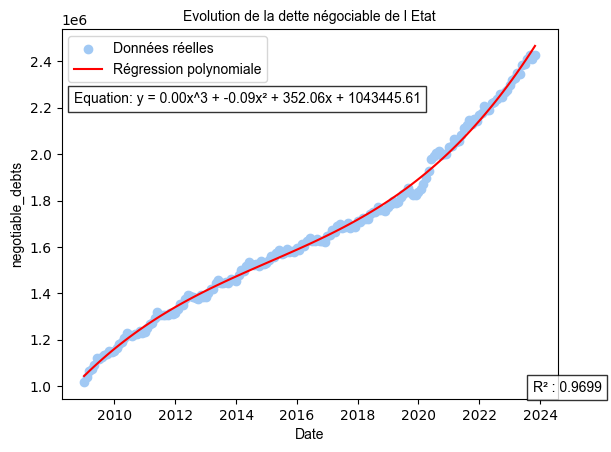

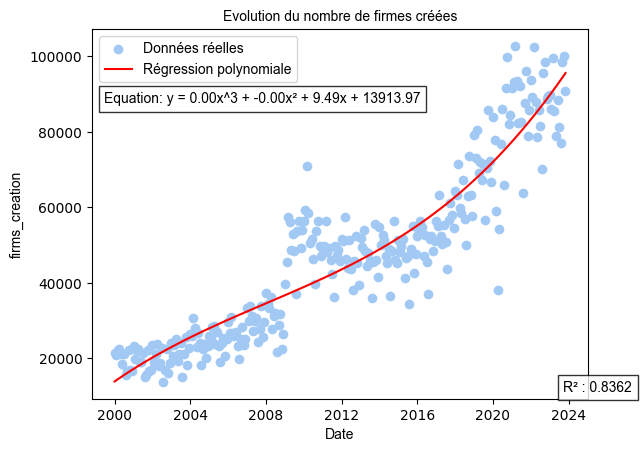

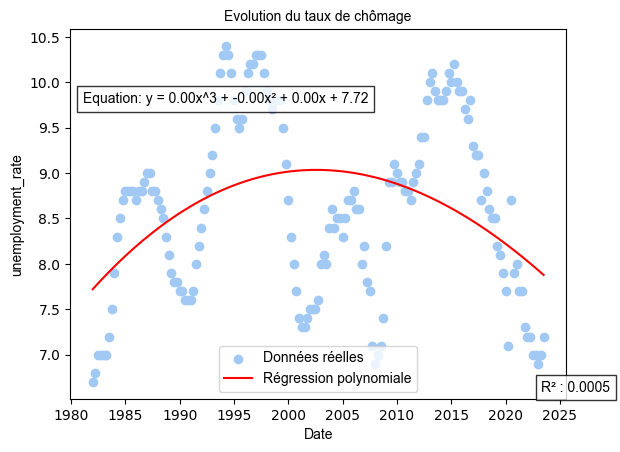

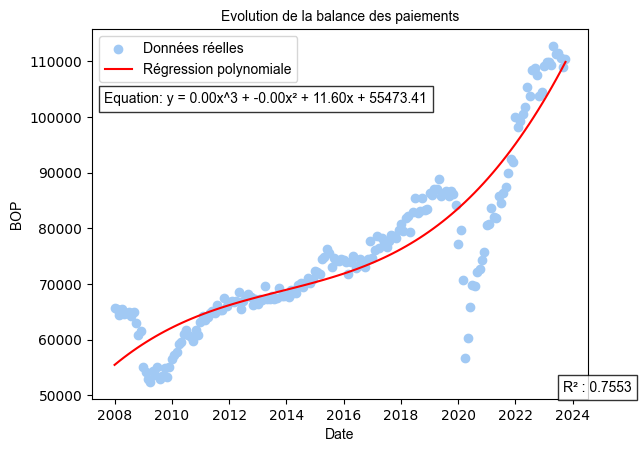

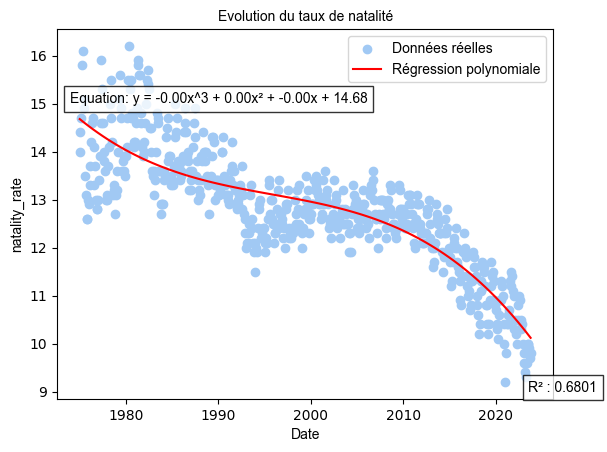

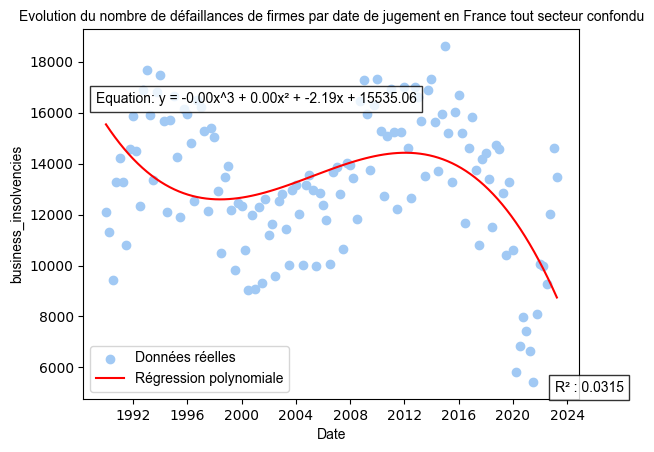

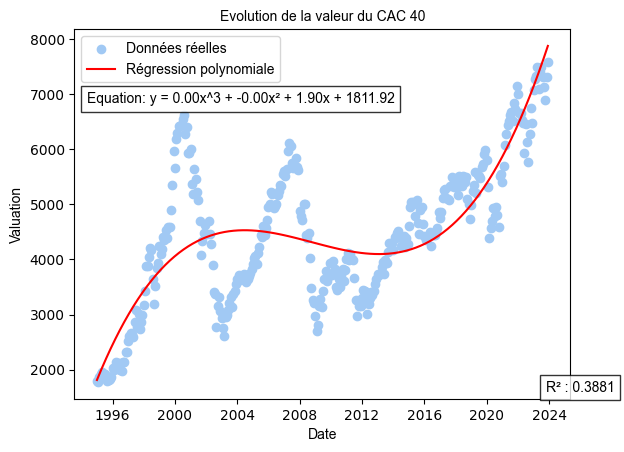

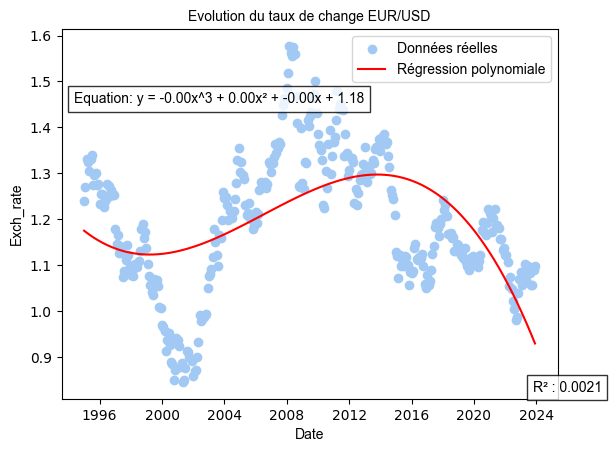

In [14]:
negotiable_debts = pd.read_csv(os.path.join(data_folder + 'negotiable_debts_filtered.csv'))
bop = pd.read_csv(os.path.join(data_folder, 'BOP_filtered.csv'))
business_insolvencies = pd.read_csv(os.path.join(data_folder, 'business_insolvencies_filtered.csv'))
firms_creation = pd.read_csv(os.path.join(data_folder, 'firms_creation_filtered.csv'))
natality_rate = pd.read_csv(os.path.join(data_folder, 'natality_rate_filtered.csv'))
unemployment_rate = pd.read_csv(os.path.join(data_folder, 'unemployment_rate_filtered.csv'))
cac_40 = pd.read_csv(os.path.join(data_folder, 'CAC_40.csv'))
eur_usd = pd.read_csv(os.path.join(data_folder, 'EUR_USD.csv'))

# Utilisation de la fonction avec spécification des noms de fichiers de sortie
create_scatter_plot(negotiable_debts, 'Evolution de la dette négociable de l Etat', 'Date', 'negotiable_debts', 'negotiable_debts_scatter.png')
create_scatter_plot(firms_creation, 'Evolution du nombre de firmes créées', 'Date', 'firms_creation', 'firms_creation_scatter.png')
create_scatter_plot(unemployment_rate, 'Evolution du taux de chômage', 'Date', 'unemployment_rate', 'unemployment_rate_scatter.png')
create_scatter_plot(bop, 'Evolution de la balance des paiements', 'Date', 'BOP', 'BOP_scatter.png')
create_scatter_plot(natality_rate, 'Evolution du taux de natalité', 'Date', 'natality_rate', 'natality_rate_scatter.png')
create_scatter_plot(business_insolvencies, 'Evolution du nombre de défaillances de firmes par date de jugement en France tout secteur confondu', 'Date', 'business_insolvencies', 'business_insolvencies_scatter.png')
create_scatter_plot(cac_40, 'Evolution de la valeur du CAC 40', 'Date', 'Valuation', 'cac_40_scatter.png')
create_scatter_plot(eur_usd, 'Evolution du taux de change EUR/USD', 'Date', 'Exch_rate', 'eur_usd_scatter.png')


On peut remarquer plusieurs éléments grâce à ces tableaux :
- **l'évolution de la dette négociable de l'Etat est relativement linéaire depuis 2009**. Cependant on peut observer un effet marginal décroissant (un coefficient de -0.09 pour x²), que l'on pourrait interpréter comme une peur du surendettement, notamment autour du seuil des 100% du PIB

- **la balance des paiements est sur une tendance positive** : la balance des paiements : contraire à l'idée reçue, la France ne dépend pas du reste du monde.Certes, la balance commerciale (i.e. la différence entre exportations et importations de marchandises) est négative, c'est avant tout lié à la position  économique française dans le monde et son passage à une économie de services, avec un fort développement du tertiaire au détriment des autres secteurs (notamment la désindustrialisation).

-   **concernant le taux de chômage, on observe de véritables cycles correspondant aux cycles macroéconomiques**:
    - au début des années 1980, une sortie du plein emploi qu'avait connu la France des Trente Glorieuses avec le contrecoup des chocs pétroliers 
    - un pic durant les années 1990 lié à une récession mondiale, conjuguée à un basculement de plein pied dans la mondialisation (notamment du secteur industriel), avant que la révolution des NTIC permette de faire baisser le chômage
    - au début des années 2000, un resserrement des taux de long-terme et une explosion de la bulle Internet induisant une hausse du chômage
    - la conjonction de la crise financière de 2008 et de la crise des dettes souveraines à partir de 2010
    - puis à partir du milieu des années 2010, une baisse du chômage liée à une baisse des taux d'intérêt afin de stimuler l'économie

    Sachant que les données remontent à 1980, il est tout à fait normal qu'une régression polynomiale de degré 3 soit incapable de saisir ce caractère cyclique, d'autant que le taux de chômage est très dépendant du contexte macroéconomique.

- **concernant l'évolution du CAC 40, on retrouve le même caractère cyclique** : 
    - la bulle Internet le place juste en-dessous des 7000 points, avant que son éclatement provoque son effondrement.
    - on observe un effondrement similaire après la crise financière de 2008 et un ralentissement de la reprise avec la crise des dettes souveraines au début des années 2010.
    - on remarque ensuite une hausse, même si des épisodes comme le Covid ou le déclenchement de la guerre en Ukraine provoquent des baisses temporaires.





## 2) Politique monétaire : taux directeurs

On s'intéresse désormais aux taux directeurs de la BCE qui dictent la politique monétaire suivie. 

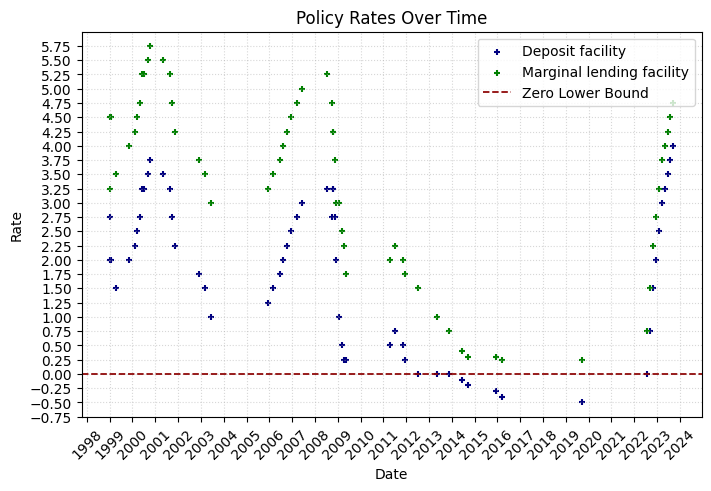

In [15]:
selected_columns = ['Date', 'Deposit facility', 'Marginal lending facility'] #Sélection des colonnes d'intérêt
policy_rates_df = pd.read_csv('datas/policy_rates.csv', usecols=selected_columns, encoding='utf-8')
policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'])

fig, ax = plt.subplots(figsize=(8, 5))

rate_colors = {'Deposit facility': 'navy', 'Marginal lending facility': 'green'}
for column in rate_colors:
    ax.scatter(policy_rates_df['Date'], policy_rates_df[column], label=column, color=rate_colors[column], marker='+', s=25)

ax.set_ylim(-0.75, 6)
ax.set_yticks(np.arange(-0.75, 6, 0.25))
ax.set_title('Policy Rates Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Rate')

#Affichage des années sur l'axe des abscisses pour une meilleure visibilité
years = mdates.YearLocator(1)
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=45)
plt.grid(linestyle=':', alpha=0.5) 

#Ajout d'une ligne horizontale pour 'Zero Lower Bound'
ax.axhline(y=0, color='darkred', linestyle='--', linewidth=1.25, label='Zero Lower Bound')  
ax.legend()

plt.savefig('data_visualisation/policy_rates_plot.png')
plt.show()

Après 2008, les banques centrales ont connu une inflation extrêmement faible, avec une possible matérialisation du risque de déflation. Pour quelles raisons y avait-il matérialisation possible du risque de déflation ?
- une baisse spectaculaire des progrès de productivité du travail et de la productivité globale des facteurs : la croissance potentielle des économies a donc diminué, donc il y avait peu de raison d’avoir une inflation forte.
- la globalisation a continué lors de cette période : les nouvelles chaînes mondiales de valeur optimisent la production de biens et de services, et donc pèsent sur les prix en intégrant par exemple des entreprises chinoises, afin d'obtenir des prix aussi bas que possibles.
- la faible capacité de la main d'oeuvre (syndicats et salariés à faible qualification) à obtenir des augmentations de rémunération - à la fois réelles et nominales. Les coûts unitaires de production sont restés très plats, donc l’inflation - corrélée à ces coûts - a peu augmenté peu.	
- enfin, un excès d’épargne au niveau mondial, provoquant des taux d’intérêt réels particulièrement bas en raison de l’excès d’épargne par rapport aux investissements souhaités

C’est pour cela que les banques centrales ont mené des politiques monétaires extraordinairement accommodantes comme le quantitative easing et les taux d'intérêt négatifs : on voit une véritable chute des taux d'intérêt directeurs, et notamment du taux marginal de prêt (taux utilisé par les banques pour emprunter à très court terme auprès de la BCE), tandis que le taux marginal de dépôt devient négatif (taux auquel les banques déposent des fonds excessifs à la BCE), encourageant ainsi l'octroi de prêts avec ces fonds plutôt que leur conservation, afin de stimuler l'activité économique. 

En revanche, le Covid a changé la situation : l'inflation a refait son entrée en Europe, et avec elle une hausse des taux directeurs. On peut l'expliquer par plusieurs raisons : 
•	la reprise post-covid : les agents ont retrouvé la capacité d’acheter, et ne sont plus inhibés par l’ensemble des contraintes du Covid : il ya augmentation de la demande, encouragée par la politique budgétaire et l'épargne Covid aussi ; mais en face la gêne du Covid a continué, ce qui fait que l'offre était encore trop insuffisante  

•	les politiques budgétaires et monétaires ultra-accommodantes jouent un grand rôle : elles se sont accumulées sur de longues périodes

•	la déglobalisation : au lieu d’une multiplication de nouvelles chaînes de valeur, il y a une tentative mondiale de se protéger des inconvénients des chaînes de valeur au niveau mondial (interruption d’un élément perturbant le reste), avec l'irruption d'éléments géostratégiques.

•	arrêt de la faible capacité de négociation du travail : on a vu l'émergence d’une certaine fureur de la classe moyenne de blue collars aux Etats Unis, et en France avec les revendications sociales. Il s'est construit une véritable critique des inégalités ainsi que des superprofits pendant le Covid.

•	d'autres raisons : un retard de réaction des banques centrales (5 mois entre l’annonce que l’inflation n’est pas seulement transitoire et la hausse des taux d’intérêt), la guerre en Ukraine, la nécesssité du financement de la transition verte (et la perspective de long-terme de la hausse des prix de certains produits) 

## 3) Plotly 

On a ensuite développé un plotly pour observer les corrélations.

NB : il est conseillé, pour des questions de visibilité, d'exécuter le code du fichier data_visualisation/plotly_plots car l'affichage est ici limité par la taille du terminal, tandis que l'exécution permet d'ouvrir une page web interactive

In [16]:
#pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

data_folder = 'datas/'
final_data = pd.read_csv(os.path.join(data_folder, 'final_data.csv'), parse_dates=['DATE'])

# Création d'une figure avec Plotly Express
fig = px.scatter_matrix(
    final_data,
    dimensions=['BOP', 'business_insolvencies', 'firms_creation', 'natality_rate', 'unemployment_rate', 'Valuation', 'Exch_rate', 'Fixed rate', 'negotiable_debts'],
    color='negotiable_debts',
    title='Relations entre différentes variables et la dette négociable'
)

# Mettre à jour l'apparence du graphique
fig.update_traces(marker=dict(size=5), diagonal_visible=False)

# Ajout du graphique de dispersion 3D
scatter_3d = go.Scatter3d(
    x=final_data['unemployment_rate'],
    y=final_data['Valuation'],
    z=final_data['negotiable_debts'],
    mode='markers',
    marker=dict(size=5, color=final_data['negotiable_debts'], colorscale='Viridis')
)

fig.add_trace(scatter_3d)
fig.update_traces(marker=dict(size=5))


# Mise à jour du layout pour ajuster l'angle des étiquettes sur l'axe y
fig.update_layout(
    title_font=dict(family='Arial', size=20, color='black'),  # Police, taille et couleur du titre
    font=dict(family='Arial', size=10, color='black'),  # Police, taille et couleur du texte
    scene=dict(
        yaxis=dict(
            title_font=dict(family='Arial', size=15, color='black'),  # Police, taille, couleur de l'axe y
            tickmode='array',
            tickvals=list(range(len(final_data.columns))),
            ticktext=list(final_data.columns),
            categoryorder='array',
            categoryarray=list(final_data.columns)
        ),
    )
)

fig.show()

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Tableau de Bord de la Dette Négociable"),

    # Filtrage temporel
    dcc.RangeSlider(
        id='date-slider',
        marks={i: str(date) for i, date in enumerate(final_data['DATE'])},
        min=0,
        max=len(final_data) - 1,
        value=[0, len(final_data) - 1],
        step=1
    ),

    # Graph principal
    dcc.Graph(id='main-graph'),
    # Graph comparatif
    dcc.Graph(id='comparison-graph')
])

# Définition des callbacks pour la mise à jour des graphiques
@app.callback(
    Output('main-graph', 'figure'),
    [Input('date-slider', 'value')]
)
def update_graph(selected_dates):
    # Extraction des données pour les dates sélectionnées
    selected_data = final_data.iloc[selected_dates[0]:selected_dates[1] + 1]

    # Graphique principal (à adapter selon vos besoins)
    main_fig = make_subplots(rows=8, cols=1, shared_xaxes=True)

    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['negotiable_debts'], mode='lines', name='Dette Négociable'), row=1, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['unemployment_rate'], mode='lines', name='Taux de Chômage'), row=2, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['BOP'], mode='lines', name='Balance des paiements - Crédit - Transactions courantes'), row=3, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['business_insolvencies'], mode='lines', name="Nombre de défaillances d'entreprises par date de jugement - Données brutes - France - Tous secteurs d'activité"), row=4, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['firms_creation'], mode='lines', name="Nombre de création d'entreprises par date de jugement - Données brutes - France - Tous secteurs d'activité"), row=5, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['natality_rate'], mode='lines', name='Taux de natalité'), row=6, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['Valuation'], mode='lines', name='Taux de change au certain €/$'), row=7, col=1)
    main_fig.add_trace(go.Scatter(x=selected_data['DATE'], y=selected_data['Fixed rate'], mode='lines', name='Taux directeur'), row=8, col=1)

    main_fig.update_layout(title='Données Sélectionnées')
    main_fig.update_layout(height=1500)

    return main_fig

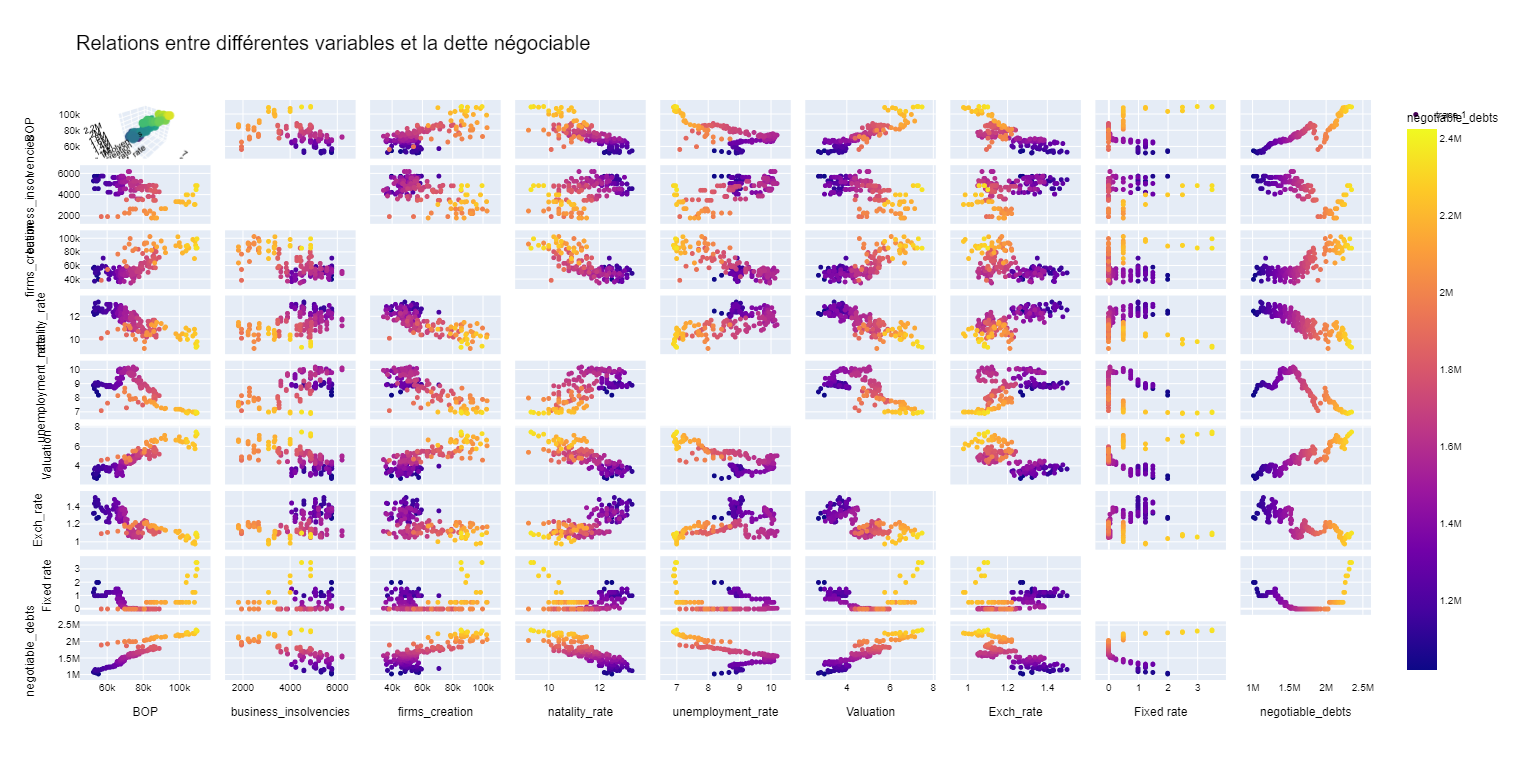

On obtient alors le graphique suivant. On peut observer la corrélation entre notre variable d'intérêt (negotiable_debts) et nos régresseurs dans les graphiques situés dans la dernière colonne : 
- une corrélation positive pour :
    - la valeur du CAC 40
    - le nombre de créations d'entreprises
    - la balance des paiements

- une corrélation négative pour :
    - le taux de change euro-dollar : 
    - le taux de natalité

- des effets plus ambigus pour : 
    - les taux directeurs
    - le taux de chômage
    - les faillites d'entreprises

Si ces éléments sont utiles, ils n'en restent que de simples observations de corrélations, ce qui n'est pas satisfaisant. L'objectif de la troisième partie est donc de préciser ces liens. 

# III Modélisation

## 1) Régression classique

In [18]:
#pip installs statsmodels

import statsmodels.api as sm
import ruptures as rpt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score

data_folder = 'datas/'

final_data = pd.read_csv(os.path.join(data_folder, 'final_data.csv'), parse_dates=['DATE'])
selected_columns = ['BOP', 'business_insolvencies', 'firms_creation', 'natality_rate', 'unemployment_rate', 'Valuation', 'Exch_rate', 'Fixed rate', 'negotiable_debts']
df = final_data[selected_columns]
data_for_regression = final_data[selected_columns]

data_for_regression = data_for_regression.dropna()

X = data_for_regression.drop(columns=['negotiable_debts'])
Y = data_for_regression['negotiable_debts']
X = sm.add_constant(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialisation du modèle de régression linéaire avec l'option robuste

model = sm.RLM(Y_train, X_train, M=sm.robust.norms.HuberT()).fit()
print(model.summary())

predictions = model.predict(X_test)

# Évaluation de la performance du modèle
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print(f'\nMean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

matrix = pd.concat([Y, X], axis=1).to_numpy()

                    Robust linear Model Regression Results                    
Dep. Variable:       negotiable_debts   No. Observations:                  137
Model:                            RLM   Df Residuals:                      128
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 30 Dec 2023                                         
Time:                        22:56:43                                         
No. Iterations:                     4                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   9.45e+

- **R²** On observe un très bon R², ce qui veut dire que notre modèle a un fort caractère prédictif. 

- **p-values** : en s'intéressant aux p-values : 
    - on voit que les taux directeurs (Fixed rate) ne sont pas significatifs au seuil de 10%. Cela peut être imputé à la forte variation des taux pendant cette période, ainsi qu'à leur maintien à des niveaux proches de 0 sur une longue période. 
    - cependant pour Fixed rate ainsi que pour le taux de change Exch_rate, l'hypothèse nulle ne peut pas être écartée au seuil de 95% (0 est compris dans l'intervalle de confiance)
    - tous les autres régresseurs sont significatifs et rejettent l'hypothèse nulle au seuil de 5%
    - tous les régresseurs, hormis la création d'entreprise (firms_rate), le taux de change (Exch_rate) et les taux directeurs (Fixed rate) sont significatifs au seuil de 1%

- **signe des coefficients** : 
    - coefficient positif :
        - taux de chômage : une augmentation d'une unité du taux de chômage a pour effet une augmentation de 6,526e4 * 10e6 € = 65,26 Mds € de la dette.  
        - valeur du CAC40 : une augmentation de 1 bps du CAC 40 a pour effet une augmentation de 65,9 M € de la dette
        - balance des paiements : une augmentation de 1M€ de la balance des paiements a pour effet une augmentation de 12,2 M € de la dette
        - création d'entreprises : une création d'entreprise en plus induit une augmentation de 1,97 M € de la dette
    
    - coefficient négatif : 
        - taux de change €/\$ : une augmentation d'une unité du taux de change au certain (ex : passer de 1€ = 1\$ à 2€ = 1\$) a pour effet une diminution de 95,2 Mds € de la dette
        - taux de natalité : une diminution d'un point du taux de natalité pour 1000 habitants d'un point (ie une diminution du nombre de naissances de 66 000) a pour effet une augmnentation de la dette de 63 Mds € 
        - faillites d'entreprises : une faillite d'entreprise supplémentaire a pour effet une diminution de la dette de 88,27 M €



Ainsi quelques uns de ces résultats peuvent nous sembler contre-intuitifs, notamment concernant les entreprises, la balance des paiements et la valeur du CAC40. On peut tenter d'expliquer ceci : 
- pour le CAC 40 et la balance des paiements, il y a une corrélation positive avec le niveau de dette, car tout au long de la période ces éléments ont évolué positivement. Il y a donc perturbation de la régression par un élément plus global (le contexte macroéconomique) 
- concernant les faillites d'entreprises, la grande chute du nombre de faillites pendant la période du Covid en raison des mesures de soutien aux entreprises
- concernant les créations d'entreprises, le coefficient est très faible et peut être mis au second plan

C'est pour cela que nous allons découper la période grâce à la détection de points de ruptures, qui devrait être plus précise.

## 2) Détection de grandes périodes et points de rupture

Nous venons donc de réaliser une régression linéaire classique afin de trouver des corrélations, significatives ou non, entre nos régresseurs et l'objet d'étude (la dette négociable de l'Etat). Cependant, il semble essentiel de souligner que ces corrélations peuvent changer au cours du temps. L'économie n'est pas un champ d'étude atemporel, certains coefficients devant des régresseurs peuvent positifs et significatifs pendant une certaine période, par exemple après la crise de 2008, puis perdre en significativité voire changer de signe pendant une période plus calme. Nous avons donc eu l'idée de trouver des grandes périodes de l'économie entre 2009 et 2023. Ces périodes se trouvent en cherchant des "points de rupture", c'est à dire des instants où les coefficients devant les régresseurs tendent à changer. 

In [19]:
# Détection de changement avec ruptures pour chaque coefficient
breakpoints = []
for i in range(X.shape[1]):
    algo = rpt.Pelt(model="rbf").fit(matrix[:, [0, i + 1]])
    result = algo.predict(pen=10)  # Vous pouvez ajuster le paramètre de pénalité
    breakpoints.append(result)

# Conversion des indices des points de rupture en un seul ensemble
breakpoints = np.unique(np.concatenate(breakpoints))
print("Points de rupture détectés :", breakpoints)

# Réinitialisation de l'index du df
final_data = final_data.reset_index(drop=True)

breakpoints = [0, 40, 85, 135, len(final_data) - 1]

Points de rupture détectés : [ 40  85 135 172]


Nous avons utilisé l'algorithme Pelt de la bibliothèque "ruptures" afin de détecter les points de rupture. Ce modèle Pelt utilise le modèle "rbf" (radial basis function) pour estimer le coût d'ajustement entre segments successifs de la série temporelle des données économiques. L'algorithme fonctionne de la manière suivante : on initie une segmentation triviale, puis on propage et ajuste itérativement cette segmentation tout en écartant les branches non prometteuses. La détection de ruptures repose sur la minimisation du coût global de la segmentation. L'Nous avons utilisé ce modèle car il permet d'identifier des périodes où les coefficients de la régression linéaire présentent des changements significatifs, facilitant ainsi l'analyse des influences temporelles sur la dette de l'État.

Ainsi, nous trouvons 4 périodes. La première démarre en janvier 2009 et se termine en mai 2012, la seconde démarre en mai 2012 et se termine en février 2016. La troisième commence en février 2016 et s'achève en avril 2020. La dernière commence en avril 2020 et se termine en 2023, lors de nos dernières données. 

Une fois ces périodes trouvées, on peut alors reproduire une régression linéaire pour chaque segment afin de visualiser, commenter et interpréter les coefficients de chaque segment. 

In [20]:
# Extraction des dates correspondantes aux points de rupture
breakpoint_dates = final_data.loc[breakpoints, 'DATE']
breakpoint_dates.iloc[0] = pd.to_datetime('2009-01-01')
breakpoint_dates.iloc[-1] = pd.to_datetime('2023-04-01')

# Division du df en segments basés sur les breakpoints
segments = []
for i in range(len(breakpoints) - 1):
    start_date = pd.to_datetime(breakpoint_dates.iloc[i])
    end_date = pd.to_datetime(breakpoint_dates.iloc[i + 1])
    segment_data = final_data[(final_data['DATE'] >= start_date) & (final_data['DATE'] < end_date)]
    segments.append(segment_data)

# Ajuster une régression linéaire robuste (Huber) pour chaque segment avec statsmodels
for i, segment_data in enumerate(segments):
    start_date = pd.to_datetime(breakpoint_dates.iloc[i])
    end_date = pd.to_datetime(breakpoint_dates.iloc[i + 1])

    X = segment_data.drop(columns=['negotiable_debts', 'DATE', 'Deposit facility', 'Marginal lending facility'])
    Y = segment_data['negotiable_debts']

    # Ajoutez une constante à X pour estimer l'ordonnée à l'origine
    X = sm.add_constant(X)

    # Créer un modèle de régression linéaire robuste (Huber) avec statsmodels    
    model = sm.RLM(Y, X, M=sm.robust.norms.HuberT()).fit()

    # Afficher les résultats sous forme de tableau
    print(f"\nSegment {i + 1} - Period: {start_date} to {end_date}")
    print(model.summary())


Segment 1 - Period: 2009-01-01 00:00:00 to 2012-05-01 00:00:00
                    Robust linear Model Regression Results                    
Dep. Variable:       negotiable_debts   No. Observations:                   40
Model:                            RLM   Df Residuals:                       31
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 30 Dec 2023                                         
Time:                        22:56:49                                         
No. Iterations:                     2                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

La première période (2009-avril 2012) est une période post-crise 2008. Comme attendu et commenté plus haut, le coefficient devant la colonne "Balance of payments", "unemployment_rate", "Valuation" sont significatifs et positif. Les coefficients devant "firms_creation", "natality_rate", "Exch_rate" et "Fixed rate" sont non significatifs sûrement dû au faible nombre de données sur cette période de 3 ans. Le coefficients devant 'business_insolvencies" est négatif mais assez faible, tout comme dans la régression globale, ce qui s'interprète donc de la même manière. Comme changement notable, la période 2009-2012 montre une amplification de l'effet de la balance des paiements sur la dette, et une relative stabilité des insolvabilités par rapport à la période complète

La seconde période, entre 2012 et 2016, est marquée par une stagnation économique, un chômage grimpant et une crise dans les échanges européens. 
Comparé au segment précédent, plusieurs changements dans les coefficients sont notables :
Le coefficient devant "BOP" diminue à 4.28, montrant une moindre dépendance aux échanges internationaux. Cela peut refléter une période de stabilisation après une croissance rapide des échanges dans le segment précédent.
Peu de coefficients sont en fait toujours significatif au seuil de 10%.

La troisième période, entre 2016 et 2020, est toujours une période dde stagnation économique. Le coeffiicient devant le taux de chômage devient significatif au niveau 1% et est trés bas. Le coefficient devant "Valuation" est significatif, comme à la première période, mais cette fois de signe opposé, il est désormais négatif. Un coefficient négatif devant "Valuation" suggère qu'une dépréciation de l'euro par rapport au dollar est associée à une diminution de la dette publique en France. Cela peut résulter de l'impact positif sur les exportations, réduisant la nécessité d'emprunter. De plus, si une part significative de la dette est libellée en devises étrangères, une dépréciation augmente sa valeur en euros. Cependant, l'interprétation dépend de divers facteurs économiques.

La dernière période, après avril 2020 est la période durant laquelle le COVID a fragilisé l'économie française. Les seuls régresseurs ayant des coefficients significatifs sont "BOP", "Fixed rate" et "Natality_rate". Ceci ne semble pas absurde dans une situation où les échanges commerciaux ont connu de fortes fluctuations (à la baisse puis à la hausse), et à un moment où la BCE a relevé ses taux afin de limiter l'inflation. Pourtant non significatif aux périodes précédentes, le coefficient de "Natality_rate" (fortement négatif) devient significatif au seuil de 1%. C'est donc uniquement sur cette période que ce coefficient est significatif, sachant qu'il l'est sur la régression faite sur l'ensemble des données. 

## 3) Essai et comparaison de nouveaux modèles prédictifs

La dernière partie de ce projet sur la dette négociable de l'Etat français vise à étudier d'autres formes de régressions, la régression linéaire n'étant pas unique. Après plusieurs recherches sur leur existence et sur leur implantation informatique, nous avons trouvé les Arbres de décisions, les Forêts aléatoires et les modèles Adaboost. 
On commencer par évaluer  quatre modèles (Régression Linéaire, Arbre de Décision, Forêt Aléatoire et AdaBoost) en utilisant la validation croisée pour calculer les scores RMSE (Root Mean Squared Error) pour chaque pli et affiche la moyenne RMSE pour chaque modèle.

Le principe ici est le suivant : La validation croisée divise l'ensemble de données en plusieurs plis et évalue le modèle sur chacun d'entre eux.
On entraine alors le modèle plusieurs fois selon le nombre de division, chaque fois en utilisant un pli différent comme ensemble de test et les autres comme ensembles d'entraînements. Puis pour chaque pli on évalue la performance en calculant le RMSE, et on fait enfin la moyenne des RMSE. 



In [21]:
df = final_data[selected_columns]
df = df.dropna()
X = df.drop('negotiable_debts', axis=1)
y = df['negotiable_debts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèles choisis
models = {
    'Régression Linéaire': LinearRegression(),
    'Arbre de Décision': DecisionTreeRegressor(),
    'Forêt Aléatoire': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor()
}

# Évaluation des modèles avec validation croisée
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = pd.Series(-scores, name="RMSE").apply(lambda x: round(x ** 0.5, 2))
    print(f"Modèle: {model_name}")
    print("RMSE scores:", rmse_scores)
    print(f"Moyenne RMSE: {rmse_scores.mean()}\n")

Modèle: Régression Linéaire
RMSE scores: 0    59336.03
1    66908.69
2    68466.28
3    63349.78
4    52888.35
Name: RMSE, dtype: float64
Moyenne RMSE: 62189.826

Modèle: Arbre de Décision
RMSE scores: 0     46314.86
1    199042.25
2     68086.41
3    114192.12
4     35113.59
Name: RMSE, dtype: float64
Moyenne RMSE: 92549.84599999999

Modèle: Forêt Aléatoire
RMSE scores: 0     23314.53
1    143757.14
2     70305.93
3     31842.67
4     53337.71
Name: RMSE, dtype: float64
Moyenne RMSE: 64511.596000000005

Modèle: AdaBoost
RMSE scores: 0    29338.91
1    30506.05
2    71553.01
3    31896.27
4    31433.19
Name: RMSE, dtype: float64
Moyenne RMSE: 38945.486



### 3-1 Interprétation des Résultats :

#### Régression Linéaire :
Les RMSE varient significativement d'un pli à l'autre.
La moyenne RMSE est relativement élevée (62189.83), indiquant une dispersion importante des erreurs de prédiction.

###Arbre de Décision :
Les RMSE sont très variables, avec un écart élevé entre le meilleur et le pire pli.
La moyenne RMSE est élevée (80897.62), suggérant une performance mitigée du modèle.

#### Forêt Aléatoire :
Les RMSE montrent une variabilité, mais moins prononcée que pour l'Arbre de Décision.
La moyenne RMSE (68686.13) est relativement élevée, indiquant que le modèle ne parvient pas à prédire de manière précise.

#### AdaBoost :
Les RMSE sont plus homogènes entre les plis par rapport à d'autres modèles.
La moyenne RMSE (35294.03) est relativement basse, suggérant une meilleure performance en termes de précision de prédiction.

Le modèle avec la moyenne RMSE la plus faible est donc le modèle Adaboost. 

### 3-2 Deuxième phase : prédiction et comparaison des modèles
L'approche ici est différente. L'objectif ici est d'appliquer les 4 modèles de régression afin de prédire la variable cible (la dette) à un instant T, par les données des régresseurs aux instants [2009-01-01 - T]. Puis, dans un second temps, comparer les prédictions des modèles entre eux, à chaque date, et les comparer à la vraie valeur de la dette à cette date donnée. 
Ensuite, le code utilise une boucle pour itérer sur les dates, entraîne les modèles sur l'ensemble d'entraînement à chaque itération, fait des prédictions sur l'ensemble de test, et stocke ces prédictions dans le DataFrame final_data. Enfin, il affiche la somme des MSE (Mean Squared Error) pour chaque modèle.

Le principe est alors le suivant : La boucle itère sur chaque date à partir de la deuxième date dans le jeu de données.À chaque itération, les données jusqu'à la date actuelle sont utilisées pour l'entraînement, tandis que les données à la date actuelle sont utilisées pour les tests.
On entraine ensuite le modèle : Pour chaque date, les modèles sélectionnés (Régression Linéaire, Arbre de Décision, Forêt Aléatoire, AdaBoost) sont entraînés sur les caractéristiques sélectionnées jusqu'à la date actuelle.Puis on fait des prédictions à la datte actuelle, la prédiction est stockée et ajoutée à la base de données pour chaque modèles. Enfin on calcule la MSE (mean squared error) pour chaque modèle

In [22]:
import warnings
from tqdm import tqdm

# Créer un dictionnaire pour stocker les métriques pour chaque modèle
metrics_scores = {model_name: {'MSE': []} for model_name in models.keys()}

# Création d'un nouveau df pour stocker les prédictions
predictions_df = pd.DataFrame()
predictions_df.dropna()

# Variables explicatives
features = ['BOP', 'business_insolvencies', 'firms_creation', 'natality_rate', 'unemployment_rate', 'Valuation', 'Exch_rate', 'Fixed rate', 'negotiable_debts']

# Création d'un dictionnaire qui stock les MSE pour chaque modèle
mse_scores = {model_name: [] for model_name in models.keys()}

# Désactiver les avertissements pendant l'exécution de la boucle
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Boucle sur les dates à partir de la deuxième date
    for i in tqdm(range(1, len(final_data))):
        # Séparation des données en ensemble d'entraînement et de test
        train_data = final_data.iloc[:i, :]
        test_data = final_data.iloc[i, :]

        # Sélection des caractéristiques et de la cible
        X_train = train_data[features]
        y_train = train_data['negotiable_debts']
        X_test = test_data[features]

        # Boucle sur les modèles
        for model_name, model in models.items():
            # Entraîner le modèle
            model.fit(X_train, y_train)
            # Faire la prédiction sur les données de test
            y_pred = model.predict(X_test.values.reshape(1, -1))
            # Ajouter les prédictions au DataFrame final_data
            final_data.at[test_data.name, f'{model_name}_Prediction'] = y_pred[0]

            # Calculer les métriques et les ajouter aux listes correspondantes
            mse = mean_squared_error([test_data['negotiable_debts']], [y_pred])

            metrics_scores[model_name]['MSE'].append(mse)

# Afficher les métriques pour chaque modèle
for model_name, metrics_dict in metrics_scores.items():
    total_mse = np.sum(metrics_dict['MSE'])
    print(f'Somme des MSE pour {model_name}: {total_mse}')
   
# Afficher les 5 dernières lignes
print("5 dernières lignes de final_data :")
print(final_data.tail())

# Afficher les 5 premières lignes
print("\n5 premières lignes de final_data :")
print(final_data.head())

100%|██████████| 171/171 [00:43<00:00,  3.96it/s]

Somme des MSE pour Régression Linéaire: 519500253.57943726
Somme des MSE pour Arbre de Décision: 97529777659.0
Somme des MSE pour Forêt Aléatoire: 200643790463.7744
Somme des MSE pour AdaBoost: 213963348872.6819
5 dernières lignes de final_data :
          DATE  negotiable_debts       BOP  business_insolvencies  \
167 2022-12-01           2277811  104521.0            4003.000000   
168 2023-01-01           2297631  109080.0            4872.000000   
169 2023-02-01           2319193  109849.0            4872.000000   
170 2023-03-01           2328956  109785.0            4872.000000   
171 2023-04-01           2352050  109339.0            4488.666667   

     firms_creation  natality_rate  unemployment_rate  Valuation  Exch_rate  \
167         89608.0           10.0           6.933333    6473.76     1.0702   
168         89832.0            9.6           6.900000    7082.42     1.0862   
169         85940.0            9.8           6.933333    7267.93     1.0576   
170         99475.0   

#### Somme des MSE pour Chaque Modèle :

La somme des MSE est la plus basse pour la Régression Linéaire, indiquant une performance globale relativement meilleure par rapport aux autres modèles.
L'Arbre de Décision a une somme des MSE très élevée, soulignant une faible capacité du modèle à généraliser.
Forêt Aléatoire et AdaBoost ont des sommes intermédiaires, avec AdaBoost présentant une performance légèrement meilleure.

#### Pourquoi les résultats diffèrent selon l'approche par les RMSE et les MSE ? 
Le RMSE moyen privilégie les modèles qui minimisent les erreurs pour chaque pli, même si cela conduit à quelques erreurs importantes.
La somme des MSE évalue les modèles en fonction de la contribution totale des erreurs, ce qui peut montrer que la Régression Linéaire a une performance plus stable sur l'ensemble des donnée. Cela peut signifier que la Régression Linéaire a moins tendance à générer des erreurs très importantes. 


En conclusion, même si le RMSE moyen pour AdaBoost semble meilleur, la somme des MSE indique que la Régression Linéaire peut présenter une performance plus stable et globalement meilleure sur l'ensemble des données. 

# Conclusion

En conclusion, ce projet a été très formateur. Nous sommes en particulier passés des fichiers python aux Notebooks, format qui a l'avantage de présenter le code et les commentaires. 
Du point de vue de la construction des données, il a fallu conjuguer des données de sources différentes, et donc avec des standards différents, avant de les unifier. Nous avons aussi été confrontés au problème de la disponibilité des données, ainsi que leur régularité (mensuel vs trimestriel vs annuel), ce qui nous a empêché de remonter aussi loin que nous l'aurions voulu. 
En particulier, la partie scraping depuis le site de la BCE a été une véritable problématique à affronter, car nous ne maitrisions pas le code html. Nous avons ainsi dû faire preuve d'ingéniosité face à l'échec des méthodes des modules traditionnels de Python.

La partie visualisation a été intéressante en ce qu'elle consiste en la présentation et communication des résultats. La partie plotly a aussi pu se révéler problématique dans son développement.

La partie modélisation fut l'occasion d'appliquer les concepts et méthodes du cours d'économétrie sur Python, ce qui a pu se révéler plus épineux car les librairies et options utilisées sur Stata ou R ne sont pas les mêmes que sur Python. Nous avons néanmoins su surmonté ces difficultés.


En définitive, même si nous le savions en commençant ce projet, nous n'avons pas révolutionné l'approche de l'évolution de la dette.Néanmoins nous avons bien pu identifier des points de rupture qui découpent la période en segments correspondant à des cycles macroéconomiques reconnus, ainsi que pu confirmer des hypothèses intuitives. 
Il nous a encouragé à éventuellement creuser ce sujet plus tard ou s'attaquer à des problématiques similaires plus en profondeur lorsque nous disposerons de plus de connaissance et d'expérience en la matière. Nous sommes en effet tous deux intéressés par l'analyse macroéconomique et nous serons sûrement amenés à retravailler sur les mêmes données que nous avons manipulé.
